In [1]:
import wrds
import pandas as pd
import numpy as np
import os
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
script_dir = os.getcwd()

# Set the working directory to the current script's directory (which in this case is already the working directory)
os.chdir(script_dir)

print(f"Working directory is set to: {script_dir}")

Working directory is set to: /Users/zrsong/MIT Dropbox/Zirui Song/Research Projects/Direct Lending/Code


# Clean Extracted Loans (Tranche_Level) from March 1st Extraction

In [2]:
extracted_loans = pd.read_csv("../Data/Raw/loan_extraction_update_250301.csv")

In [3]:
# Drop rows where any column between lender_name and maturity_months is missing
filtered_loans = extracted_loans.dropna(subset=[
    'lender_name', 
    'borrower_name', 
    'multiple_facilities',
    'facility_type',
    'facility_active_date',
    'facility_maturity_date',
    'facility_amount',
    'maturity_months',
    'secured',
    'interest_rate',
    'lead_arranger',
])

# Print the shape before and after filtering
print(f"Original shape: {extracted_loans.shape}")
print(f"After dropping missing values: {filtered_loans.shape}")

# Show a sample of the filtered data
filtered_loans.head()

Original shape: (18491, 31)
After dropping missing values: (13641, 31)


,accession,filename,type_filing,type_attachment,date,form_type,loan,amendment,targeted_scope,reasoning,...,lowest_rate,highest_rate,monthly_fs,projected_fs,lender_meeting,gvkey,CIK,lead_arranger,standardized_lead_arranger,lcoid
0,0000950116-96-000036,0000950116-96-000036_0007.txt,10-K405,EX-10.(AB),1996-01-29,10-K405,1,0,0,The lender is identified as 'First Fidelity Ba...,...,LIBOR + 2%,LIBOR + 5%,0,0,0,11904.0,766041,First Fidelity Bank,First Fidelity Bank,NaN
1,0000950116-96-000036,0000950116-96-000036_0007.txt,10-K405,EX-10.(AB),1996-01-29,10-K405,1,0,0,The lender is identified as 'First Fidelity Ba...,...,LIBOR + 2%,LIBOR + 5%,0,0,0,11904.0,766041,First Fidelity Bank,First Fidelity Bank,NaN
2,0000077543-96-000003,0000077543-96-000003_0001.txt,10-K,EX-10,1996-03-27,10-K,1,0,0,The contract outlines a bridge credit agreemen...,...,LIBOR + 2%,LIBOR + 2%,0,0,0,8486.0,77543,Morgan Guaranty Trust Company of New York,Morgan Guaranty Trust,6031.0
4,0000950152-97-008892,0000950152-97-008892_0002.txt,8-K,EX-10.1,1997-12-30,8-K,1,0,0,The contract outlines a credit agreement betwe...,...,NaN,NaN,0,0,0,16747.0,215403,"Strategic Acquisition Partners, LLC","Strategic Acquisition Partners, LLC",NaN
9,0001047469-99-030604,0001047469-99-030604_0001.txt,10-Q,EX-10.1,1999-08-10,10-Q,1,0,0,The loan agreement primarily identifies the Ca...,...,NaN,NaN,0,0,0,148317.0,1042465,California Infrastructure and Economic Develop...,California Infrastructure and Economic Develop...,NaN


Summary statistics for interest rates:
count    11885.000000
mean         3.527421
std          5.320140
min          0.000000
25%          1.250000
50%          2.250000
75%          4.500000
max        100.000000
Name: clean_rate, dtype: float64

Number of loans with interest rates > 20%: 52
Number of loans with interest rates > 50%: 31


/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_19392/2552011422.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_loans.loc[:, 'interest_rate_pct'] = filtered_loans['interest_rate'].apply(extract_interest_rate)
/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_19392/2552011422.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_loans.loc[:, 'lowest_rate_pct'] = filtered_loans['lowest_rate'].apply(extract_interest_rate)
/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq

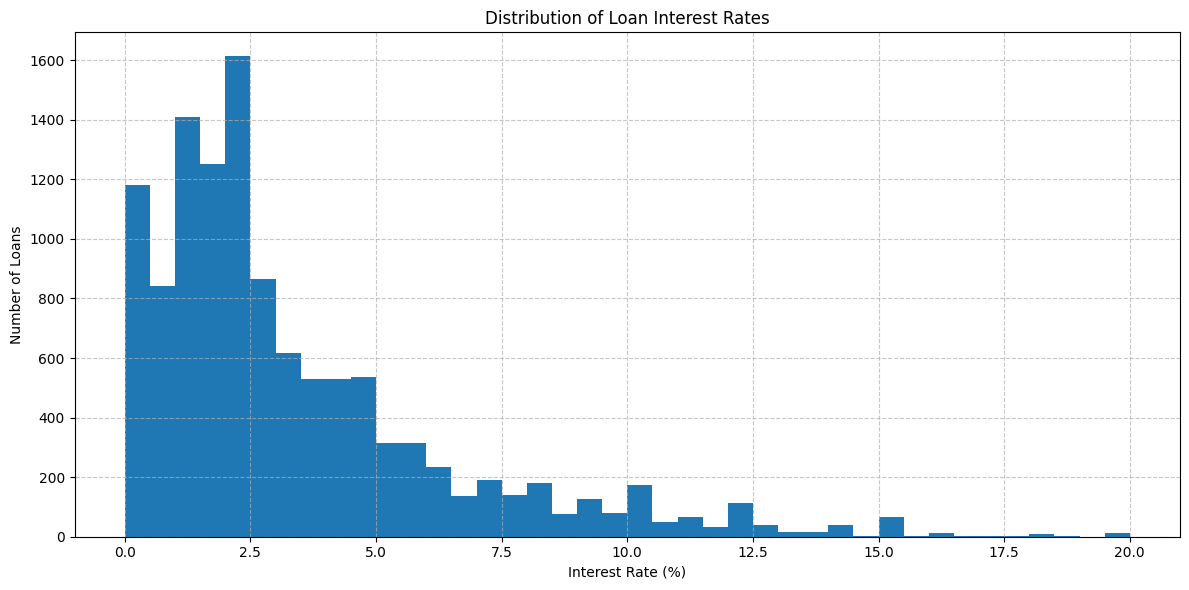

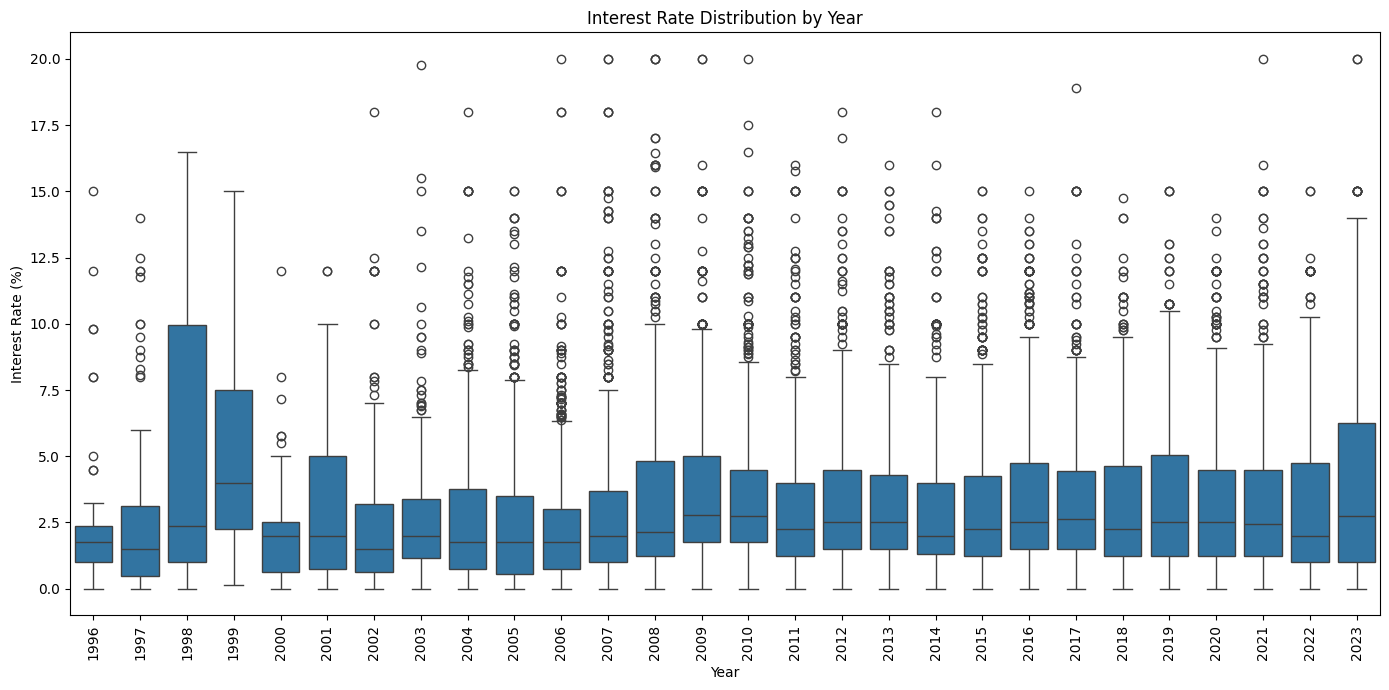

In [4]:
import re

# Define a function to extract numeric interest rates from string
def extract_interest_rate(rate_str):
    if pd.isna(rate_str):
        return np.nan
    
    # Convert to string to handle any non-string inputs
    rate_str = str(rate_str).upper()
    
    # Common patterns in the data
    if 'LIBOR' in rate_str or 'SOFR' in rate_str or 'PRIME' in rate_str:
        # Extract numbers following + or following "to" (for ranges)
        matches = re.findall(r'[+]\s*(\d+\.?\d*)', rate_str)
        if matches:
            return float(matches[0])
        
        # Check for percentage values
        percent_matches = re.findall(r'(\d+\.?\d*)%', rate_str)
        if percent_matches:
            return float(percent_matches[0])
    else:
        # For direct percentage values
        percent_matches = re.findall(r'(\d+\.?\d*)%', rate_str)
        if percent_matches:
            return float(percent_matches[0])
    
    return np.nan

# Apply the function to clean the interest rate columns
filtered_loans.loc[:, 'interest_rate_pct'] = filtered_loans['interest_rate'].apply(extract_interest_rate)
filtered_loans.loc[:, 'lowest_rate_pct'] = filtered_loans['lowest_rate'].apply(extract_interest_rate)
filtered_loans.loc[:, 'highest_rate_pct'] = filtered_loans['highest_rate'].apply(extract_interest_rate)

# Create a combined interest rate column (using lowest when available, otherwise interest_rate)
filtered_loans.loc[:, 'clean_rate'] = filtered_loans['lowest_rate_pct'].fillna(filtered_loans['interest_rate_pct'])

# Check for rates greater than 100 and adjust them
for col in ['interest_rate_pct', 'lowest_rate_pct', 'highest_rate_pct', 'clean_rate']:
    # Create a mask for values > 100
    mask = filtered_loans[col] > 100
    # Apply division only to those values
    filtered_loans.loc[mask, col] = filtered_loans.loc[mask, col] / 100

# Display summary statistics of the clean_rate column
rate_stats = filtered_loans['clean_rate'].describe()
print("Summary statistics for interest rates:")
print(rate_stats)

# Check for extreme values (potentially erroneous)
print("\nNumber of loans with interest rates > 20%:", (filtered_loans['clean_rate'] > 20).sum())
print("Number of loans with interest rates > 50%:", (filtered_loans['clean_rate'] > 50).sum())

# Filter out extreme values (likely data errors)
filtered_loans = filtered_loans[filtered_loans['clean_rate'].isna() | (filtered_loans['clean_rate'] <= 20)]

# Create histogram of interest rates
plt.figure(figsize=(12, 6))
filtered_loans['clean_rate'].hist(bins=40)
plt.title('Distribution of Loan Interest Rates')
plt.xlabel('Interest Rate (%)')
plt.ylabel('Number of Loans')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Convert date to datetime format and extract year (if not already done)
if 'year' not in filtered_loans.columns:
    filtered_loans['year'] = pd.to_datetime(filtered_loans['date']).dt.year

# Plot interest rates over time
plt.figure(figsize=(14, 7))
sns.boxplot(x='year', y='clean_rate', data=filtered_loans)
plt.title('Interest Rate Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Interest Rate (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [5]:
# drop if clean_rate is missing
filtered_loans = filtered_loans.dropna(subset=['clean_rate'])

In [6]:
generic_patterns = [
    'lender party', 'lender parties', 'the lender', 
    'lender hereto', 'lenders hereto', 'the lenders',
    'party hereto', 'parties hereto', 'each lender',
    'various lenders', 'various purchasers', 'various investors',
    'not found', 'not applicable', 'not available', 'not identified',
    'several lenders', 'time warner',
]

# Convert patterns into a regex pattern
pattern = '|'.join(generic_patterns)

# Replace generic lender descriptions with NaN
filtered_loans.loc[filtered_loans['lead_arranger'].str.contains(pattern, case=False, na=False), 'lead_arranger'] = np.nan
filtered_loans.loc[filtered_loans['standardized_lead_arranger'].str.contains(pattern, case=False, na=False), 'standardized_lead_arranger'] = np.nan

# drop if both lead arranger and standardized lead arranger are missing
filtered_loans = filtered_loans.dropna(subset=['lead_arranger', 'standardized_lead_arranger'], how='all')


          date  year
0   1996-01-29  1996
1   1996-01-29  1996
2   1996-03-27  1996
10  1999-08-18  1999
11  2001-11-16  2001

Number of loans by year:
year
1996     64
1997     76
1998     54
1999     48
2000     47
2001     93
2002    127
2003    208
2004    452
2005    529
2006    623
2007    663
2008    575
2009    387
2010    685
2011    818
2012    578
2013    539
2014    577
2015    587
2016    531
2017    532
2018    475
2019    456
2020    467
2021    628
2022    528
2023    327
Name: count, dtype: int64


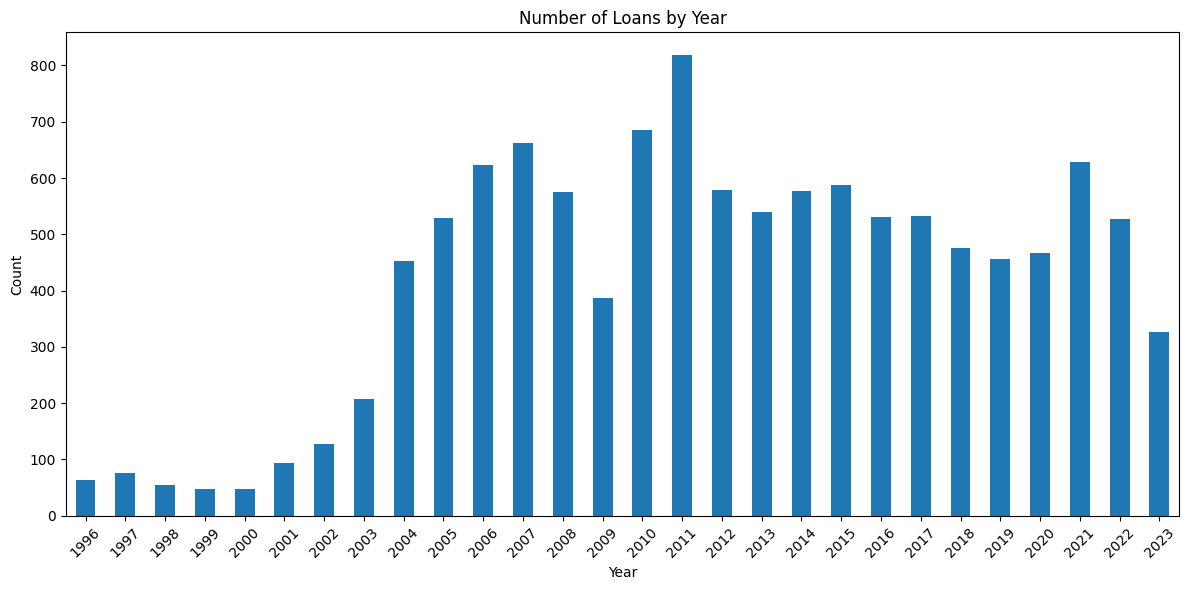

In [7]:
# Convert date to datetime format and extract year
filtered_loans['year'] = pd.to_datetime(filtered_loans['date']).dt.year

# Display the first few rows to verify
print(filtered_loans[['date', 'year']].head())

# Count loans by year
year_counts = filtered_loans['year'].value_counts().sort_index()
print("\nNumber of loans by year:")
print(year_counts)

# Plot the number of loans by year
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar')
plt.title('Number of Loans by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

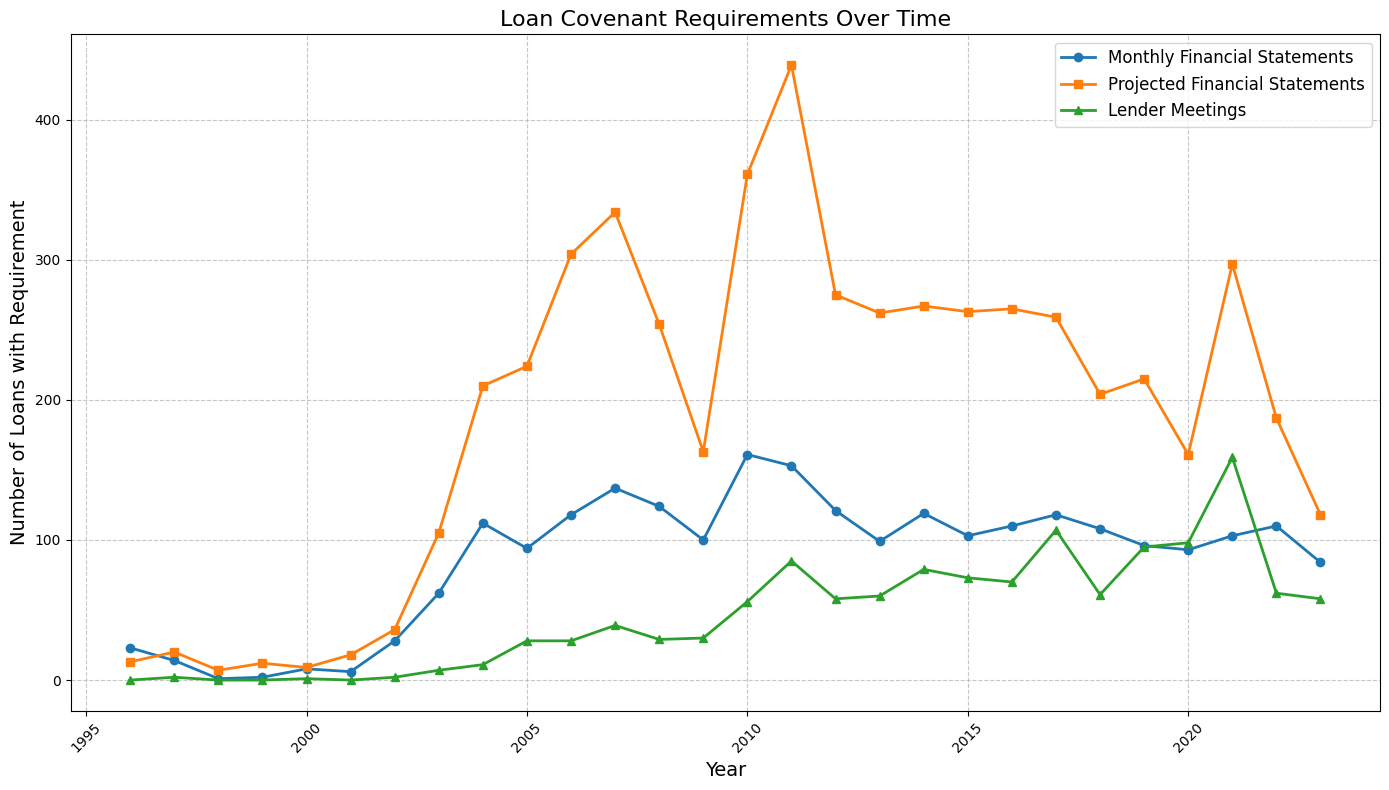

Percentage of loans with each requirement by year:
    Year  Monthly FS (%)  Projected FS (%)  Lender Meeting (%)
0   1996            35.9              20.3                 0.0
1   1997            18.4              26.3                 2.6
2   1998             1.9              13.0                 0.0
3   1999             4.2              25.0                 0.0
4   2000            17.0              19.1                 2.1
5   2001             6.5              19.4                 0.0
6   2002            22.0              28.3                 1.6
7   2003            29.8              50.5                 3.4
8   2004            24.8              46.5                 2.4
9   2005            17.8              42.3                 5.3
10  2006            18.9              48.8                 4.5
11  2007            20.7              50.4                 5.9
12  2008            21.6              44.2                 5.0
13  2009            25.8              42.1                 7.8
14  

In [8]:
# Group by year and count the occurrences where each variable equals 1
monthly_fs_by_year = filtered_loans.groupby('year')['monthly_fs'].sum()
projected_fs_by_year = filtered_loans.groupby('year')['projected_fs'].sum()
lender_meeting_by_year = filtered_loans.groupby('year')['lender_meeting'].sum()

# Create a figure with appropriate size
plt.figure(figsize=(14, 8))

# Plot line charts for each variable
plt.plot(monthly_fs_by_year.index, monthly_fs_by_year.values, marker='o', linewidth=2, label='Monthly Financial Statements')
plt.plot(projected_fs_by_year.index, projected_fs_by_year.values, marker='s', linewidth=2, label='Projected Financial Statements')
plt.plot(lender_meeting_by_year.index, lender_meeting_by_year.values, marker='^', linewidth=2, label='Lender Meetings')

# Add labels and title
plt.title('Loan Covenant Requirements Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Loans with Requirement', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show years with appropriate rotation
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Calculate and print the percentage of each requirement by year
percentage_df = pd.DataFrame({
    'Year': monthly_fs_by_year.index,
    'Monthly FS (%)': (monthly_fs_by_year / year_counts * 100).values,
    'Projected FS (%)': (projected_fs_by_year / year_counts * 100).values,
    'Lender Meeting (%)': (lender_meeting_by_year / year_counts * 100).values
})

print("Percentage of loans with each requirement by year:")
print(percentage_df.round(1))

In [9]:
# Define bank terms to exclude
bank_terms = ['bank', 'jpmorgan', 'citibank', 'wells fargo', 'morgan stanley', 'credit suisse', 
              'merrill lynch', 'goldman sachs', 'barclays', 'bayerische', 'bbva', 'bear', 'bmo', 
              'bnp paribas', 'bofa', 'capital one', 'cibc', 'citicorp', 'citigroup',
              'citizens', 'credit lyonnais', 'goldman', 'hsbc', 'j.p. morgan', 'j. p. morgan', 
              'jpmorgan', 'jp morgan', 'lehman brothers', 'merrill', 'pnc', 'rbc', 'rbs', 
              'societe generale', 'suntrust', 'toronto dominion', 'ubs', 'société générale', 
              'harris', 'westlb', 'bancorp', 'bancshares', 'bancgroup', 'national association',
              'lehman', 'jefferies', 'abn amro', 'barclay', 'cantor fitzgerald']

# Define a list of common private credit terms
private_credit = [
    'ares', 'apollo', 'blackrock', 'blackstone', 'cerberus', 'fortress', 
    'golub', 'kkr', 'oaktree', 'tpg', 'carlyle', 'bain capital', 'antares',
    'private equity', 'private credit', 'venture', 'mezzanine', 'abc', 
    'alter domus', 'athene', 'athyrium', 'bain', 'biopharma', 
    'blue ridge', 'blue torch', 'brookfield', 'fund',
    'canada pension plan investment board', 'cap 1 llc', 'carter', 'centre lane', 
    'cf capital llc', 'cf equipment loans', 'cf turul llc', 
    'chambers energy management', 'chatham credit', 'churchill', 'colfin', 
    'comvest', 'cortland capital market', 'cortland products', 'cpp', 'cyan partners', 
    'db realty', 'db structured', 'deerfield', 'eclipse business', 'eig', 'ej funds', 
    'elliott', 'encina', 'enervest', 'enhanced capital', 'ept ski properties',
    'escalate', 'evergreen solar', 'evolve transition', 'fiera private', 'fifth street finance', 
    'five mile capital', 'fleet capital corporation', 'fleet retail', 
    'four winds funding', 'gacp', 'gci capital', 'goldentree', 'gpc partners', 
    'gso', 'guggenheim', 'hercules technology', 'hersha mezz', 'high street capital', 
    'highbridge', 'hps investment', 'hv capital investors', 'inter-americas investment corporation', 
    'whitney mezzanine', 'jcf affm debt', 'jha', 'kayne anderson', 'laminar direct capital', 
    'lasalle business', 'laurus master fund', 'lion capital', 'loan core capital', 'isb funding llc', 
    'macquarie capital', 'madison capital funding', 'madison dearborn', 'mclarity capital', 
    'egg investment group lp', 'mid islandi sf.', 'midcap', 'monroe capital', 'newstar', 
    'northwest farm credit services', 'obsidian', 'orion energy', 'owl rock', 
    'pathlight', 'pdl biopharma', 'patriot capital', 'pepi capital', 'praesidian', 'rhône', 
    'riverstone', 'rock', 'sales capital partners', 'siena lending group', 'silver lake', 'silver point', 
    'sixth street', 'solar capital', 'squadron capital', 'standard general', 'swk', 'tangshan caofeidian', 
    'tc', 'tcf', 'tcw', 'tennenbaum', 'thermo', 'third eye capital corporation', 'thl', 'tpg specialty', 
    'victory park management', 'wynnefield capital', 'z investment', 'sell credit opportunities',
    'plexus', '1903 partners', 'ag energy funding', 'amp capital', 'strategic capital fund', 'agamerica lending',
    'agwest', 'antara', 'mortgage capital', 'bpcr', 'cit northbridge', 'deerpath funding', 'elanus capital',
    'emerald creek', 'full circle capital', 'healthcare royalty partners', 'iep energy', 'inter-american investment',
    'kaynes solution', 'laurel capital', 'macquarie', 'mclarty', 'mgg investment', 'marquette', 'mustang lodging funding',
    'orbimed', 'pcam credit', 'perceptive credit', 'pennymac', 'prudential capital', 'rhi investments', 'red mortgage capital',
    'revere credit', 'salus capital', 'solar senior capital','sts master fund', 'tpc investments', 'financial funding',
    'hayfin', 'healthcare finance group'
]

# Create functions to identify lender types
def is_nonbank_lender(lender):
    
    lender_lower = str(lender).lower()
    
    # If contains any bank term, it's a bank
    if any(bank_term in lender_lower for bank_term in bank_terms):
        return 0
    
    # Otherwise it's a nonbank
    return 1

def is_private_credit_lender(lender):
    
    lender_lower = str(lender).lower()
    
    # If it contains any private credit term
    if any(pc_term in lender_lower for pc_term in private_credit):
        return 1
    
    return 0

# Apply the functions to create nonbank_lender flag
filtered_loans['nonbank_lender_lead'] = filtered_loans['lead_arranger'].apply(is_nonbank_lender)
filtered_loans['nonbank_lender_standardized'] = filtered_loans['standardized_lead_arranger'].apply(is_nonbank_lender)
filtered_loans['nonbank_lender'] = filtered_loans['nonbank_lender_lead'] & filtered_loans['nonbank_lender_standardized']

# Apply the function to create private_credit_lender flag 
filtered_loans['private_credit_lender_lead'] = filtered_loans['lead_arranger'].apply(is_private_credit_lender)
filtered_loans['private_credit_lender_standardized'] = filtered_loans['standardized_lead_arranger'].apply(is_private_credit_lender)
filtered_loans['private_credit_lender'] = filtered_loans['private_credit_lender_lead'] | filtered_loans['private_credit_lender_standardized']

# replace private_credit_lender = 0 if nonbank_lender = 0
filtered_loans.loc[filtered_loans['nonbank_lender'] == 0, 'private_credit_lender'] = 0


(<Figure size 1400x700 with 1 Axes>,
 {'nonbank_count': 2414,
  'private_credit_count': 764,
  'total_lenders': 11621,
  'nonbank_percentage': 20.772739006970138,
  'private_credit_percentage': 6.574305137251528,
  'nonbank_by_year': year
  1996    18.750000
  1997    25.000000
  1998    27.777778
  1999    33.333333
  2000    29.787234
  2001    17.204301
  2002    22.834646
  2003    21.634615
  2004    18.141593
  2005    18.525520
  2006    22.953451
  2007    17.647059
  2008    17.217391
  2009    21.705426
  2010    14.160584
  2011    13.569682
  2012    17.647059
  2013    19.851577
  2014    16.811092
  2015    19.931857
  2016    24.858757
  2017    20.112782
  2018    22.526316
  2019    25.219298
  2020    29.122056
  2021    24.203822
  2022    26.704545
  2023    31.804281
  Name: nonbank_lender, dtype: float64,
  'private_credit_by_year': year
  1996     0.000000
  1997     2.631579
  1998     1.851852
  1999     0.000000
  2000     0.000000
  2001     1.075269
  2002  

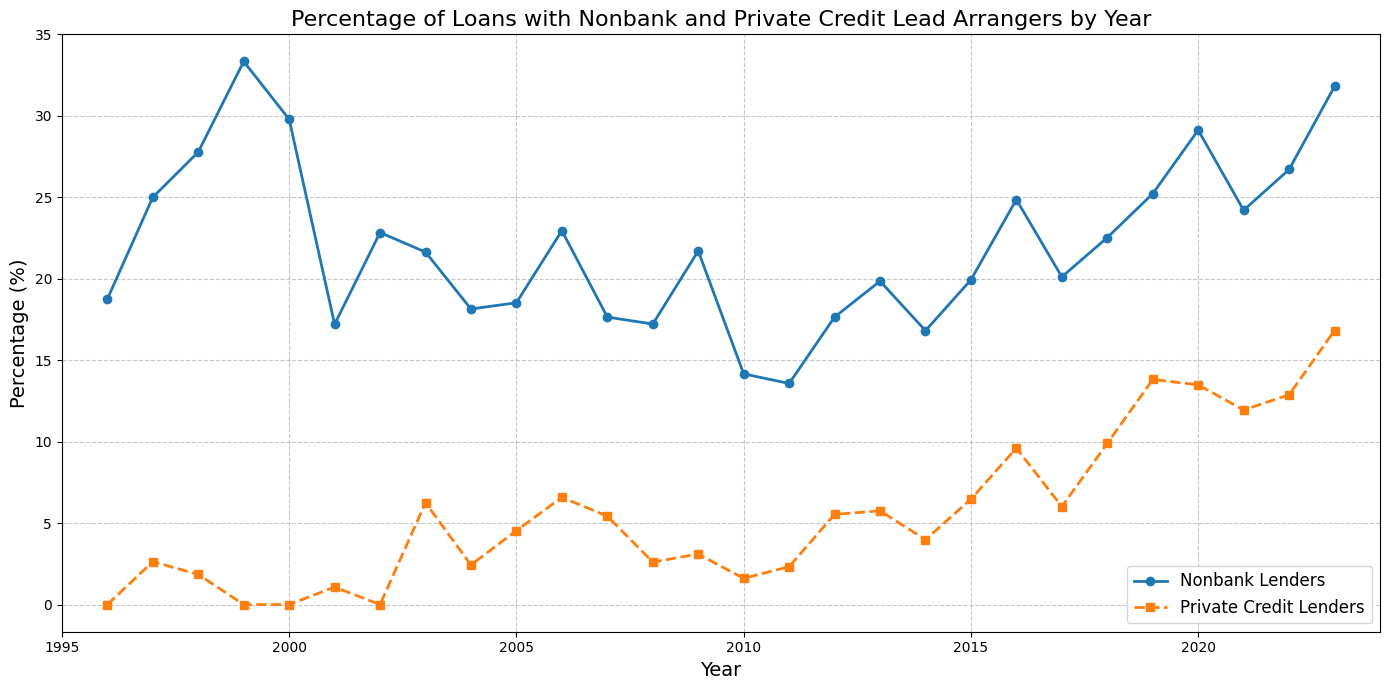

In [10]:
def plot_lender_type_trends(filtered_loans, start_year=1995, end_year=2024, figsize=(14, 7)):
    """
    Plot trends of nonbank and private credit lenders over time.
    
    Parameters:
    -----------
    filtered_loans : DataFrame
        DataFrame containing loan data with lender type information
    start_year : int
        Starting year for the x-axis range
    end_year : int
        Ending year for the x-axis range
    figsize : tuple
        Figure size as (width, height)
    
    Returns:
    --------
    fig : matplotlib Figure
        The figure with the plot
    stats : dict
        Dictionary with summary statistics
    """
    # Check the counts
    nonbank_count = filtered_loans['nonbank_lender'].sum()
    private_credit_count = filtered_loans['private_credit_lender'].sum()
    total_valid_lenders = filtered_loans['lead_arranger'].notna().sum()
    
    # Calculate percentages
    nonbank_pct = nonbank_count / total_valid_lenders * 100
    private_credit_pct = private_credit_count / total_valid_lenders * 100
    
    # Display distribution by year
    nonbank_by_year = filtered_loans.groupby('year')['nonbank_lender'].mean() * 100
    private_credit_by_year = filtered_loans.groupby('year')['private_credit_lender'].mean() * 100
    
    # Create figure for the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the trends over time
    ax.plot(nonbank_by_year.index, nonbank_by_year.values, marker='o', linewidth=2, label='Nonbank Lenders')
    ax.plot(private_credit_by_year.index, private_credit_by_year.values, marker='s', linewidth=2, linestyle='--', label='Private Credit Lenders')
    
    # Set labels and title
    ax.set_title('Percentage of Loans with Nonbank and Private Credit Lead Arrangers by Year', fontsize=16)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Percentage (%)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set appropriate x-axis range
    ax.set_xlim(start_year, end_year)
    
    # Format plot
    plt.tight_layout()
    
    # Compile statistics to return
    stats = {
        'nonbank_count': nonbank_count,
        'private_credit_count': private_credit_count,
        'total_lenders': total_valid_lenders,
        'nonbank_percentage': nonbank_pct,
        'private_credit_percentage': private_credit_pct,
        'nonbank_by_year': nonbank_by_year,
        'private_credit_by_year': private_credit_by_year
    }
    
    return fig, stats

# Example usage:
# fig, stats = plot_lender_type_trends(filtered_loans)
# plt.show()
# print(f"Overall, {stats['nonbank_percentage']:.1f}% of loans have nonbank lenders")
# print(f"Overall, {stats['private_credit_percentage']:.1f}% of loans have private credit lenders")

# Call the function to see the plot
plot_lender_type_trends(filtered_loans)

(<Figure size 1400x1800 with 3 Axes>,
     Year  Bank Loans  Nonbank Loans  Private Credit Loans  \
 0   1996          52             12                     0   
 1   1997          57             19                     2   
 2   1998          39             15                     1   
 3   1999          32             16                     0   
 4   2000          33             14                     0   
 5   2001          77             16                     1   
 6   2002          98             29                     0   
 7   2003         163             45                    13   
 8   2004         370             82                    11   
 9   2005         431             98                    24   
 10  2006         480            143                    41   
 11  2007         546            117                    36   
 12  2008         476             99                    15   
 13  2009         303             84                    12   
 14  2010         588           

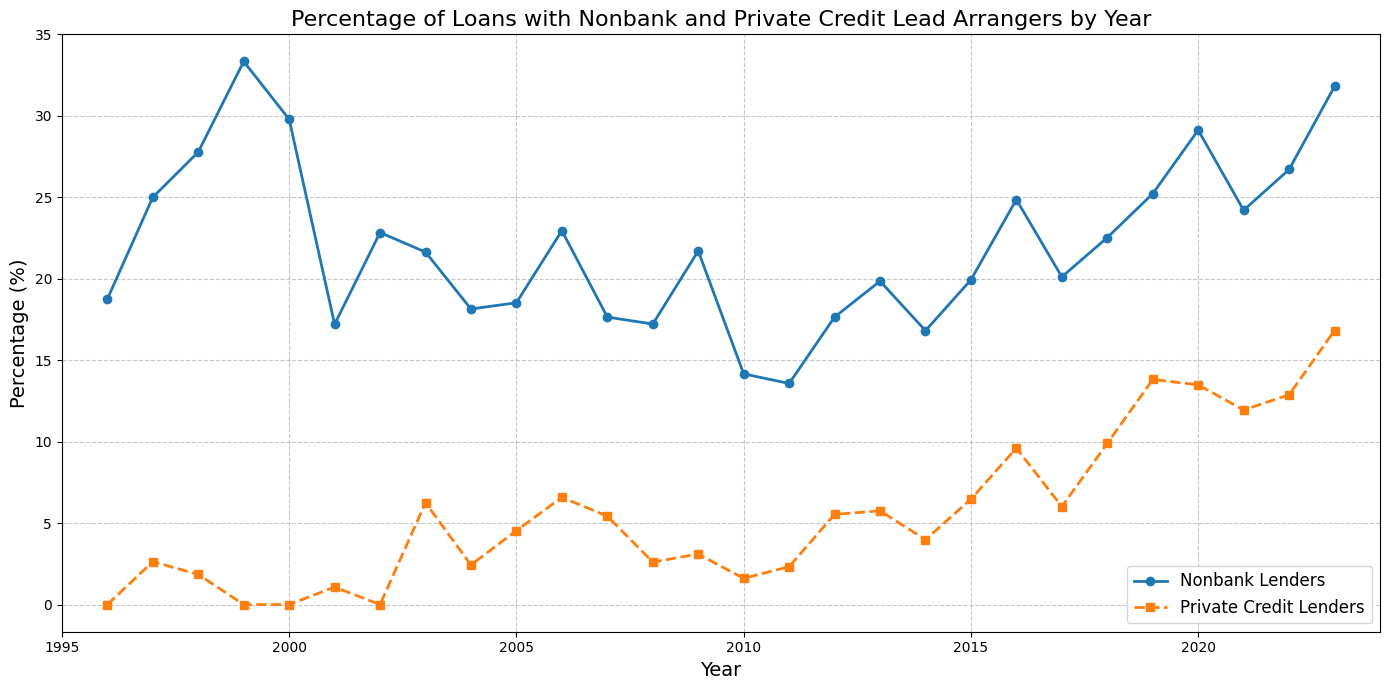

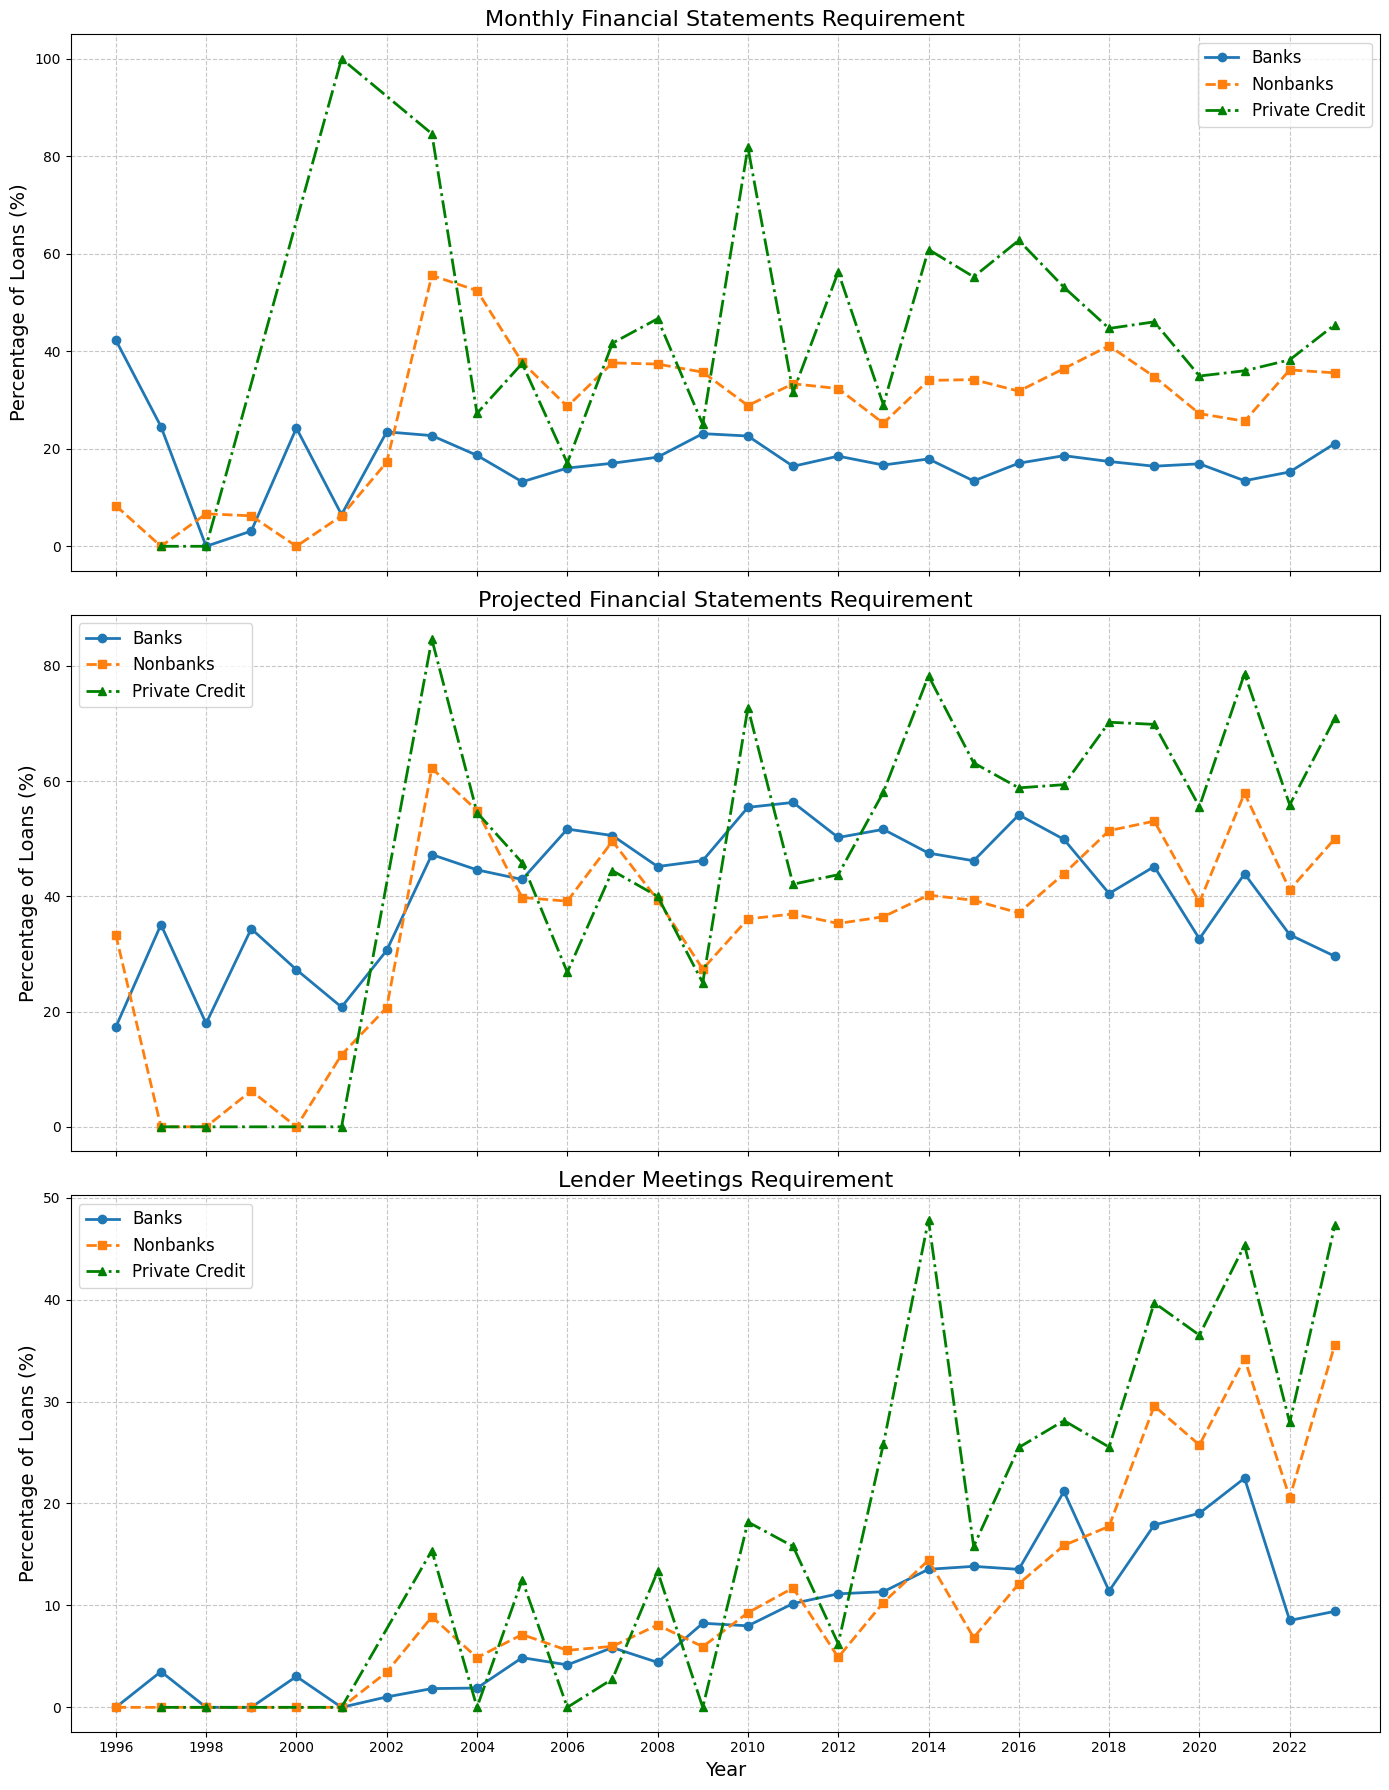

In [11]:
def plot_covenant_requirements_by_lender_type(filtered_loans, start_year=1995, end_year=2024, figsize=(14, 18)):
    """
    Create plots comparing covenant requirements across different types of lenders
    
    Parameters:
    -----------
    filtered_loans : DataFrame
        DataFrame containing loan data with covenant information
    start_year : int
        Starting year for the x-axis range
    end_year : int
        Ending year for the x-axis range
    figsize : tuple
        Figure size as (width, height)
        
    Returns:
    --------
    fig : matplotlib Figure
        The figure with the plots
    summary_df : DataFrame
        Summary dataframe with covenant requirements by lender type
    """
    # Create dataframes for banks, nonbanks, and private credit
    bank_loans = filtered_loans[filtered_loans['nonbank_lender'] == 0]
    nonbank_loans = filtered_loans[filtered_loans['nonbank_lender'] == 1]
    private_credit_loans = filtered_loans[filtered_loans['private_credit_lender'] == 1]

    # Group by year and calculate percentages for banks
    bank_monthly_pct = bank_loans.groupby('year')['monthly_fs'].mean() * 100
    bank_projected_pct = bank_loans.groupby('year')['projected_fs'].mean() * 100
    bank_meeting_pct = bank_loans.groupby('year')['lender_meeting'].mean() * 100

    # Group by year and calculate percentages for nonbanks
    nonbank_monthly_pct = nonbank_loans.groupby('year')['monthly_fs'].mean() * 100
    nonbank_projected_pct = nonbank_loans.groupby('year')['projected_fs'].mean() * 100
    nonbank_meeting_pct = nonbank_loans.groupby('year')['lender_meeting'].mean() * 100

    # Group by year and calculate percentages for private credit
    pc_monthly_pct = private_credit_loans.groupby('year')['monthly_fs'].mean() * 100
    pc_projected_pct = private_credit_loans.groupby('year')['projected_fs'].mean() * 100
    pc_meeting_pct = private_credit_loans.groupby('year')['lender_meeting'].mean() * 100

    # Create a figure with 3 subplots (one for each covenant type)
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)

    # Plot Monthly Financial Statements
    axes[0].plot(bank_monthly_pct.index, bank_monthly_pct.values, marker='o', linewidth=2, label='Banks')
    axes[0].plot(nonbank_monthly_pct.index, nonbank_monthly_pct.values, marker='s', linewidth=2, linestyle='--', label='Nonbanks')
    axes[0].plot(pc_monthly_pct.index, pc_monthly_pct.values, marker='^', linewidth=2, linestyle='-.', color='green', label='Private Credit')
    axes[0].set_title('Monthly Financial Statements Requirement', fontsize=16)
    axes[0].set_ylabel('Percentage of Loans (%)', fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    axes[0].legend(fontsize=12)

    # Plot Projected Financial Statements
    axes[1].plot(bank_projected_pct.index, bank_projected_pct.values, marker='o', linewidth=2, label='Banks')
    axes[1].plot(nonbank_projected_pct.index, nonbank_projected_pct.values, marker='s', linewidth=2, linestyle='--', label='Nonbanks')
    axes[1].plot(pc_projected_pct.index, pc_projected_pct.values, marker='^', linewidth=2, linestyle='-.', color='green', label='Private Credit')
    axes[1].set_title('Projected Financial Statements Requirement', fontsize=16)
    axes[1].set_ylabel('Percentage of Loans (%)', fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    axes[1].legend(fontsize=12)

    # Plot Lender Meetings
    axes[2].plot(bank_meeting_pct.index, bank_meeting_pct.values, marker='o', linewidth=2, label='Banks')
    axes[2].plot(nonbank_meeting_pct.index, nonbank_meeting_pct.values, marker='s', linewidth=2, linestyle='--', label='Nonbanks')
    axes[2].plot(pc_meeting_pct.index, pc_meeting_pct.values, marker='^', linewidth=2, linestyle='-.', color='green', label='Private Credit')
    axes[2].set_title('Lender Meetings Requirement', fontsize=16)
    axes[2].set_xlabel('Year', fontsize=14)
    axes[2].set_ylabel('Percentage of Loans (%)', fontsize=14)
    axes[2].grid(True, linestyle='--', alpha=0.7)
    axes[2].legend(fontsize=12)

    # Format x-axis to show years
    for ax in axes:
        ax.set_xticks(sorted(bank_loans['year'].unique())[::2])  # Show every other year to avoid crowding
        ax.set_xlim(start_year, end_year)

    plt.tight_layout()
    
    # Create a summary table that includes all three lender types
    years = sorted(filtered_loans['year'].unique())
    summary_data = []

    for year in years:
        bank_count = bank_loans[bank_loans['year'] == year].shape[0]
        nonbank_count = nonbank_loans[nonbank_loans['year'] == year].shape[0]
        pc_count = private_credit_loans[private_credit_loans['year'] == year].shape[0]
        
        if bank_count > 0 and nonbank_count > 0:
            row = {
                'Year': year,
                'Bank Loans': bank_count,
                'Nonbank Loans': nonbank_count,
                'Private Credit Loans': pc_count,
                'Bank Monthly FS (%)': bank_monthly_pct.get(year, 0),
                'Nonbank Monthly FS (%)': nonbank_monthly_pct.get(year, 0),
                'PC Monthly FS (%)': pc_monthly_pct.get(year, 0),
                'Bank Projected FS (%)': bank_projected_pct.get(year, 0),
                'Nonbank Projected FS (%)': nonbank_projected_pct.get(year, 0),
                'PC Projected FS (%)': pc_projected_pct.get(year, 0),
                'Bank Lender Meeting (%)': bank_meeting_pct.get(year, 0),
                'Nonbank Lender Meeting (%)': nonbank_meeting_pct.get(year, 0),
                'PC Lender Meeting (%)': pc_meeting_pct.get(year, 0)
            }
            summary_data.append(row)

    summary_df = pd.DataFrame(summary_data)
    
    # Calculate the average across all years for each lender type
    avg_bank = {
        'Monthly FS': bank_monthly_pct.mean(),
        'Projected FS': bank_projected_pct.mean(),
        'Lender Meeting': bank_meeting_pct.mean()
    }

    avg_nonbank = {
        'Monthly FS': nonbank_monthly_pct.mean(),
        'Projected FS': nonbank_projected_pct.mean(),
        'Lender Meeting': nonbank_meeting_pct.mean()
    }

    avg_pc = {
        'Monthly FS': pc_monthly_pct.mean(),
        'Projected FS': pc_projected_pct.mean(),
        'Lender Meeting': pc_meeting_pct.mean()
    }
    
    return fig, summary_df, (avg_bank, avg_nonbank, avg_pc)

# Example usage:
# fig, summary_df, avg_stats = plot_covenant_requirements_by_lender_type(filtered_loans)
# plt.show()
# 
# # Print a more compact version with just the key columns
# print("Summary of Covenant Requirements by Lender Type:")
# compact_df = summary_df[['Year', 'Bank Loans', 'Nonbank Loans', 'Private Credit Loans', 
#                          'Bank Monthly FS (%)', 'Nonbank Monthly FS (%)', 'PC Monthly FS (%)',
#                          'Bank Lender Meeting (%)', 'Nonbank Lender Meeting (%)', 'PC Lender Meeting (%)']].round(1)
# print(compact_df)
#
# avg_bank, avg_nonbank, avg_pc = avg_stats
# print("\nAverage Covenant Requirements (%):")
# print(f"Banks: Monthly FS = {avg_bank['Monthly FS']:.1f}%, Projected FS = {avg_bank['Projected FS']:.1f}%, Lender Meeting = {avg_bank['Lender Meeting']:.1f}%")
# print(f"Nonbanks: Monthly FS = {avg_nonbank['Monthly FS']:.1f}%, Projected FS = {avg_nonbank['Projected FS']:.1f}%, Lender Meeting = {avg_nonbank['Lender Meeting']:.1f}%")
# print(f"Private Credit: Monthly FS = {avg_pc['Monthly FS']:.1f}%, Projected FS = {avg_pc['Projected FS']:.1f}%, Lender Meeting = {avg_pc['Lender Meeting']:.1f}%")

plot_lender_type_trends(filtered_loans)
plot_covenant_requirements_by_lender_type(filtered_loans)

# Merge with Quarterly Compustat for Final Sample 

In [12]:
# Load the Compustat quarterly data
compustat_quarterly = pd.read_csv("../Data/Cleaned/crsp_compustat_quarterly_cleaned.csv")
# drop year column
compustat_quarterly = compustat_quarterly.drop(columns=['year'])

# Convert facility active date to datetime and extract year and quarter
filtered_loans['date'] = pd.to_datetime(filtered_loans['date'])
filtered_loans['year'] = filtered_loans['date'].dt.year
filtered_loans['quarter'] = filtered_loans['date'].dt.quarter

merged_data = pd.merge(
    filtered_loans,
    compustat_quarterly,
    how='inner',
    left_on=['gvkey', 'year', 'quarter'],
    right_on=['gvkey', 'fyearq', 'fqtr']
)


(<Figure size 1400x1800 with 3 Axes>,
     Year  Bank Loans  Nonbank Loans  Private Credit Loans  \
 0   1996          36             11                     0   
 1   1997          43             13                     2   
 2   1998          24              6                     1   
 3   1999          19              7                     0   
 4   2000          25             12                     0   
 5   2001          55             13                     1   
 6   2002          72             16                     0   
 7   2003         111             24                     9   
 8   2004         240             46                     6   
 9   2005         297             50                    10   
 10  2006         324             78                    18   
 11  2007         334             59                    15   
 12  2008         326             54                     8   
 13  2009         204             45                     3   
 14  2010         388           

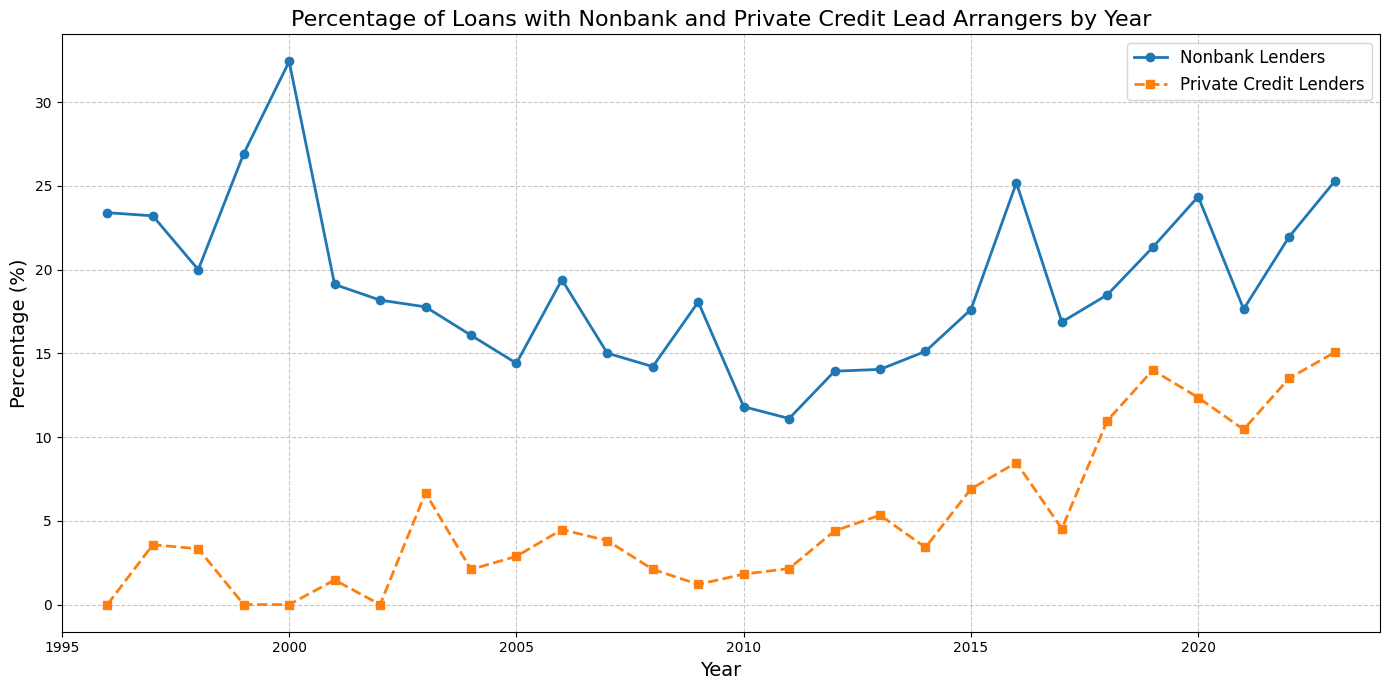

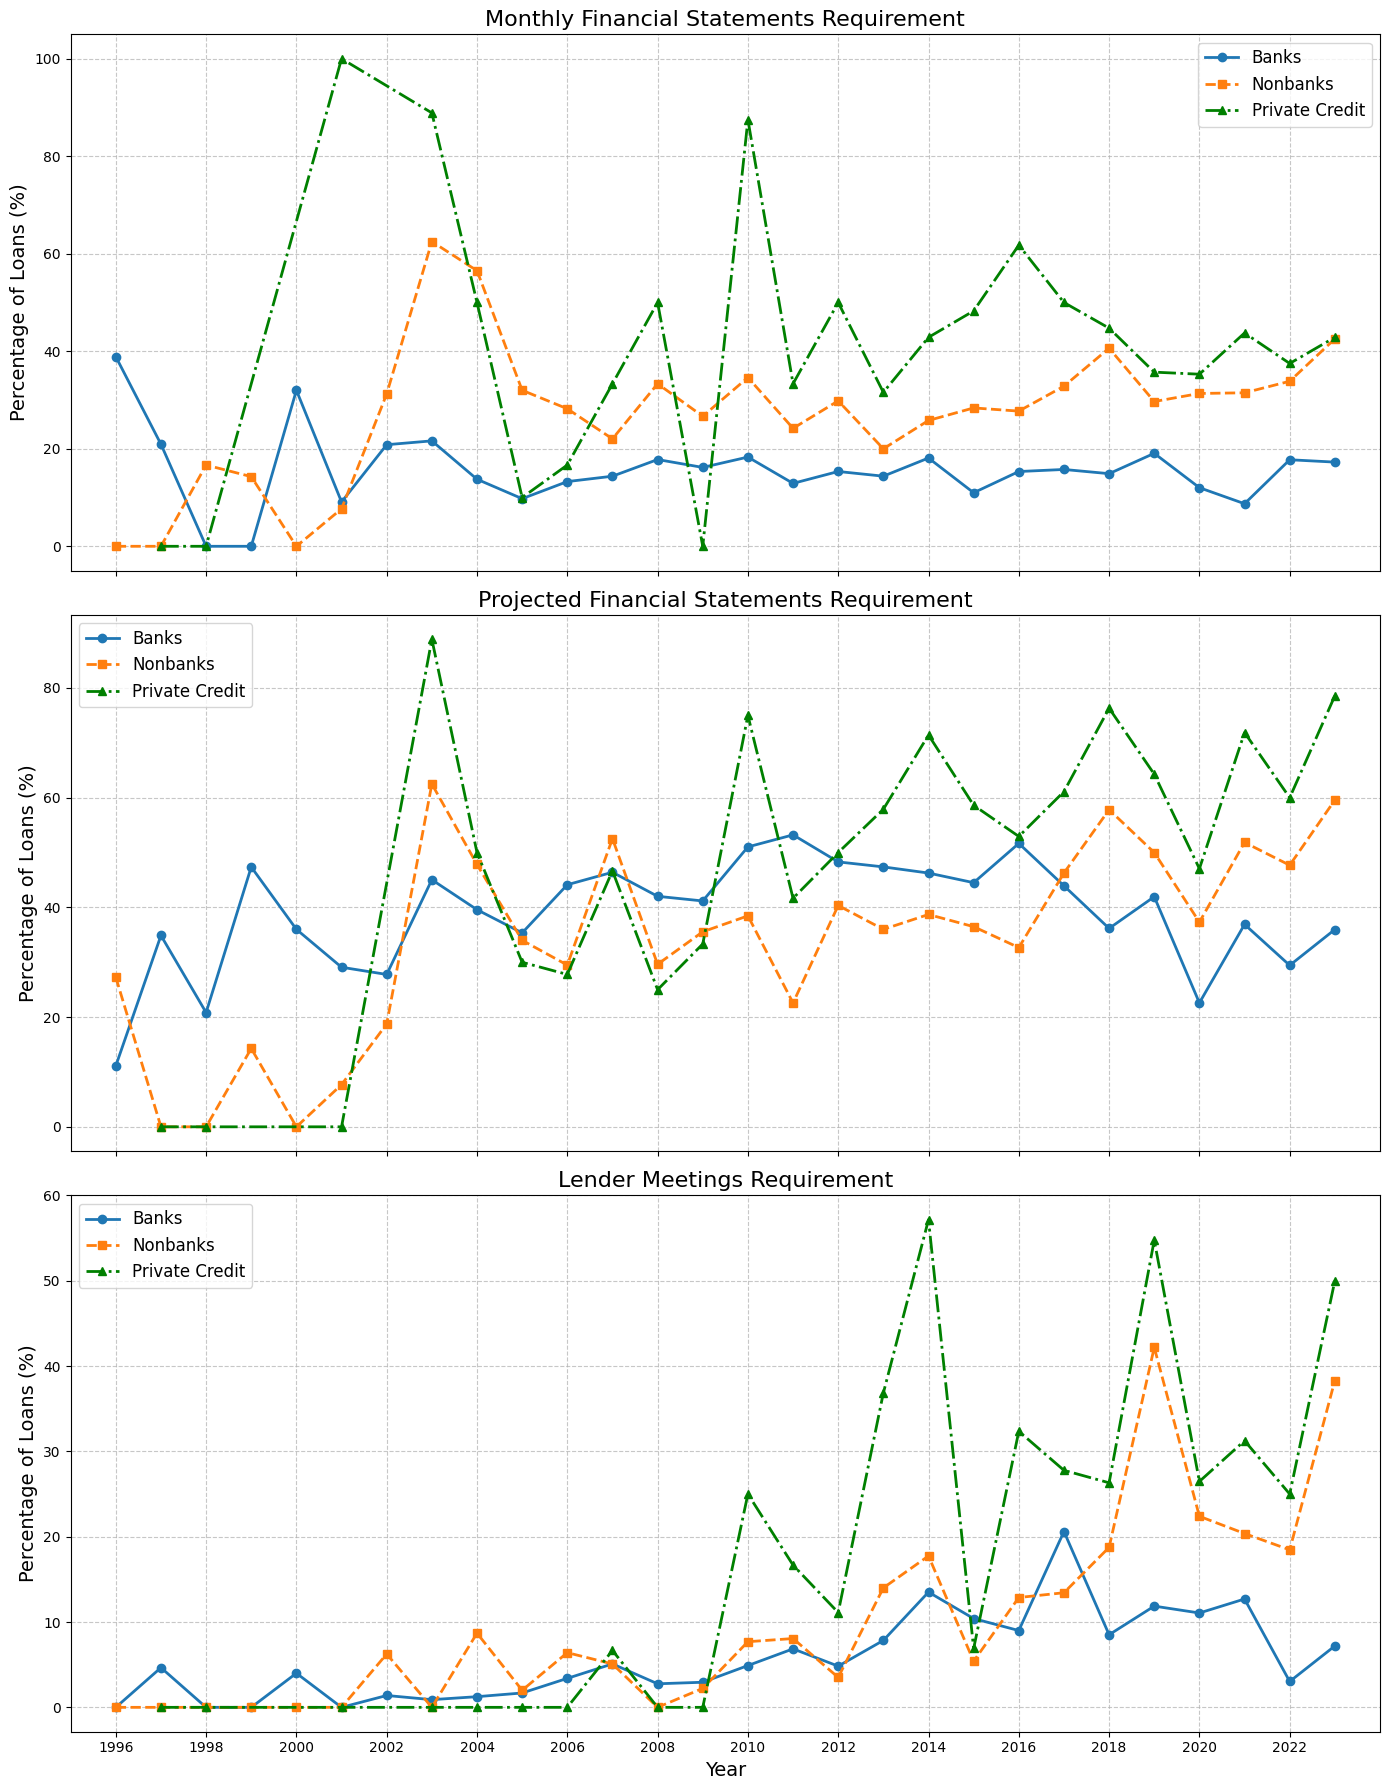

In [13]:
plot_lender_type_trends(merged_data)
plot_covenant_requirements_by_lender_type(merged_data)

In [14]:
# Filter the data to include only loans from 2010 onwards
merged_data = merged_data[merged_data['year'] >= 2010].copy()

In [15]:
# Convert facility_amount and maturity_months to numeric
merged_data['facility_amount'] = pd.to_numeric(merged_data['facility_amount'], errors='coerce')
merged_data['maturity_months'] = pd.to_numeric(merged_data['maturity_months'], errors='coerce')
# drop if either is missing
merged_data = merged_data.dropna(subset=['facility_amount', 'maturity_months'])

In [16]:
# manual check of lender names
# drop if pcof 1, llc; valhi; alliance 2000 occurs in lead_arranger
merged_data = merged_data[~merged_data['lead_arranger'].str.contains('pcof 1, llc', case=False, na=False)]
merged_data = merged_data[~merged_data['lead_arranger'].str.contains('valhi', case=False, na=False)]
merged_data = merged_data[~merged_data['lead_arranger'].str.contains('alliance 2000', case=False, na=False)]

(<Figure size 1400x1800 with 3 Axes>,
     Year  Bank Loans  Nonbank Loans  Private Credit Loans  \
 0   2010         386             52                     8   
 1   2011         490             62                    12   
 2   2012         352             57                    18   
 3   2013         303             50                    19   
 4   2014         347             59                    13   
 5   2015         341             73                    28   
 6   2016         299            100                    34   
 7   2017         328             67                    18   
 8   2018         279             64                    38   
 9   2019         233             63                    42   
 10  2020         204             67                    34   
 11  2021         247             54                    32   
 12  2022         230             65                    40   
 13  2023         138             45                    28   
 
     Bank Monthly FS (%)  Nonb

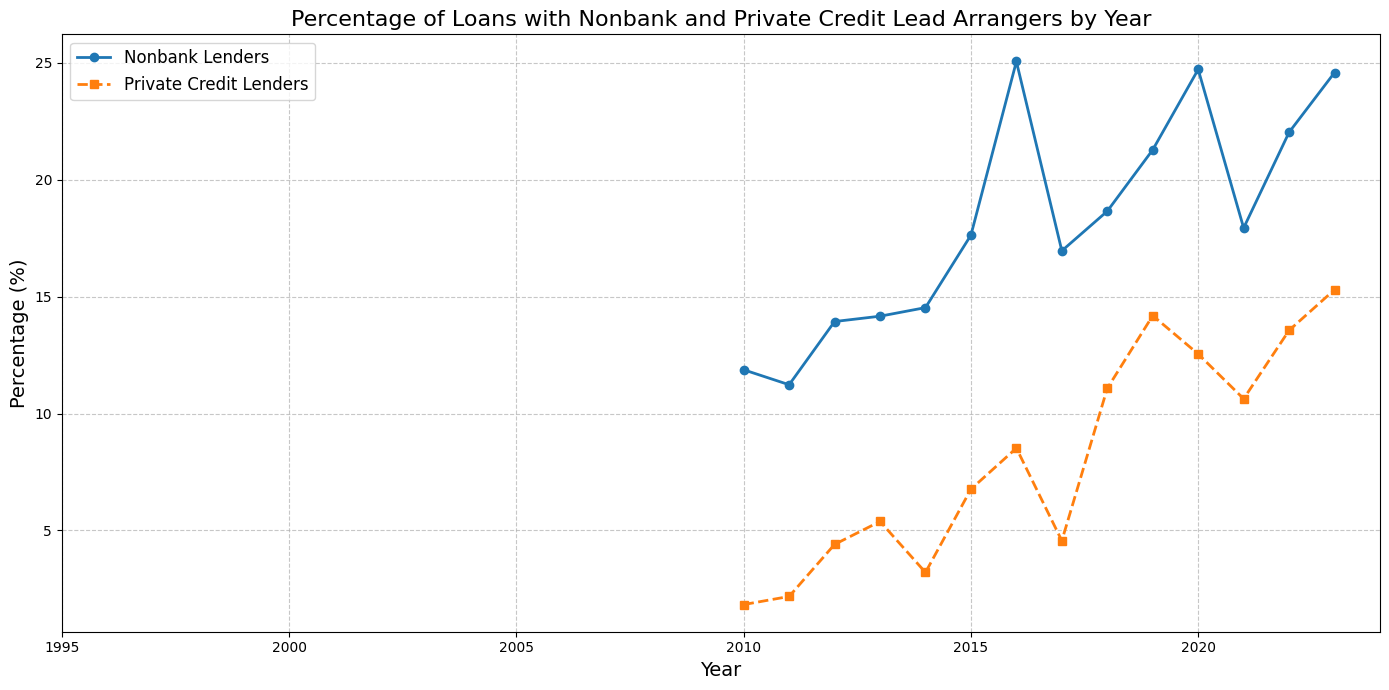

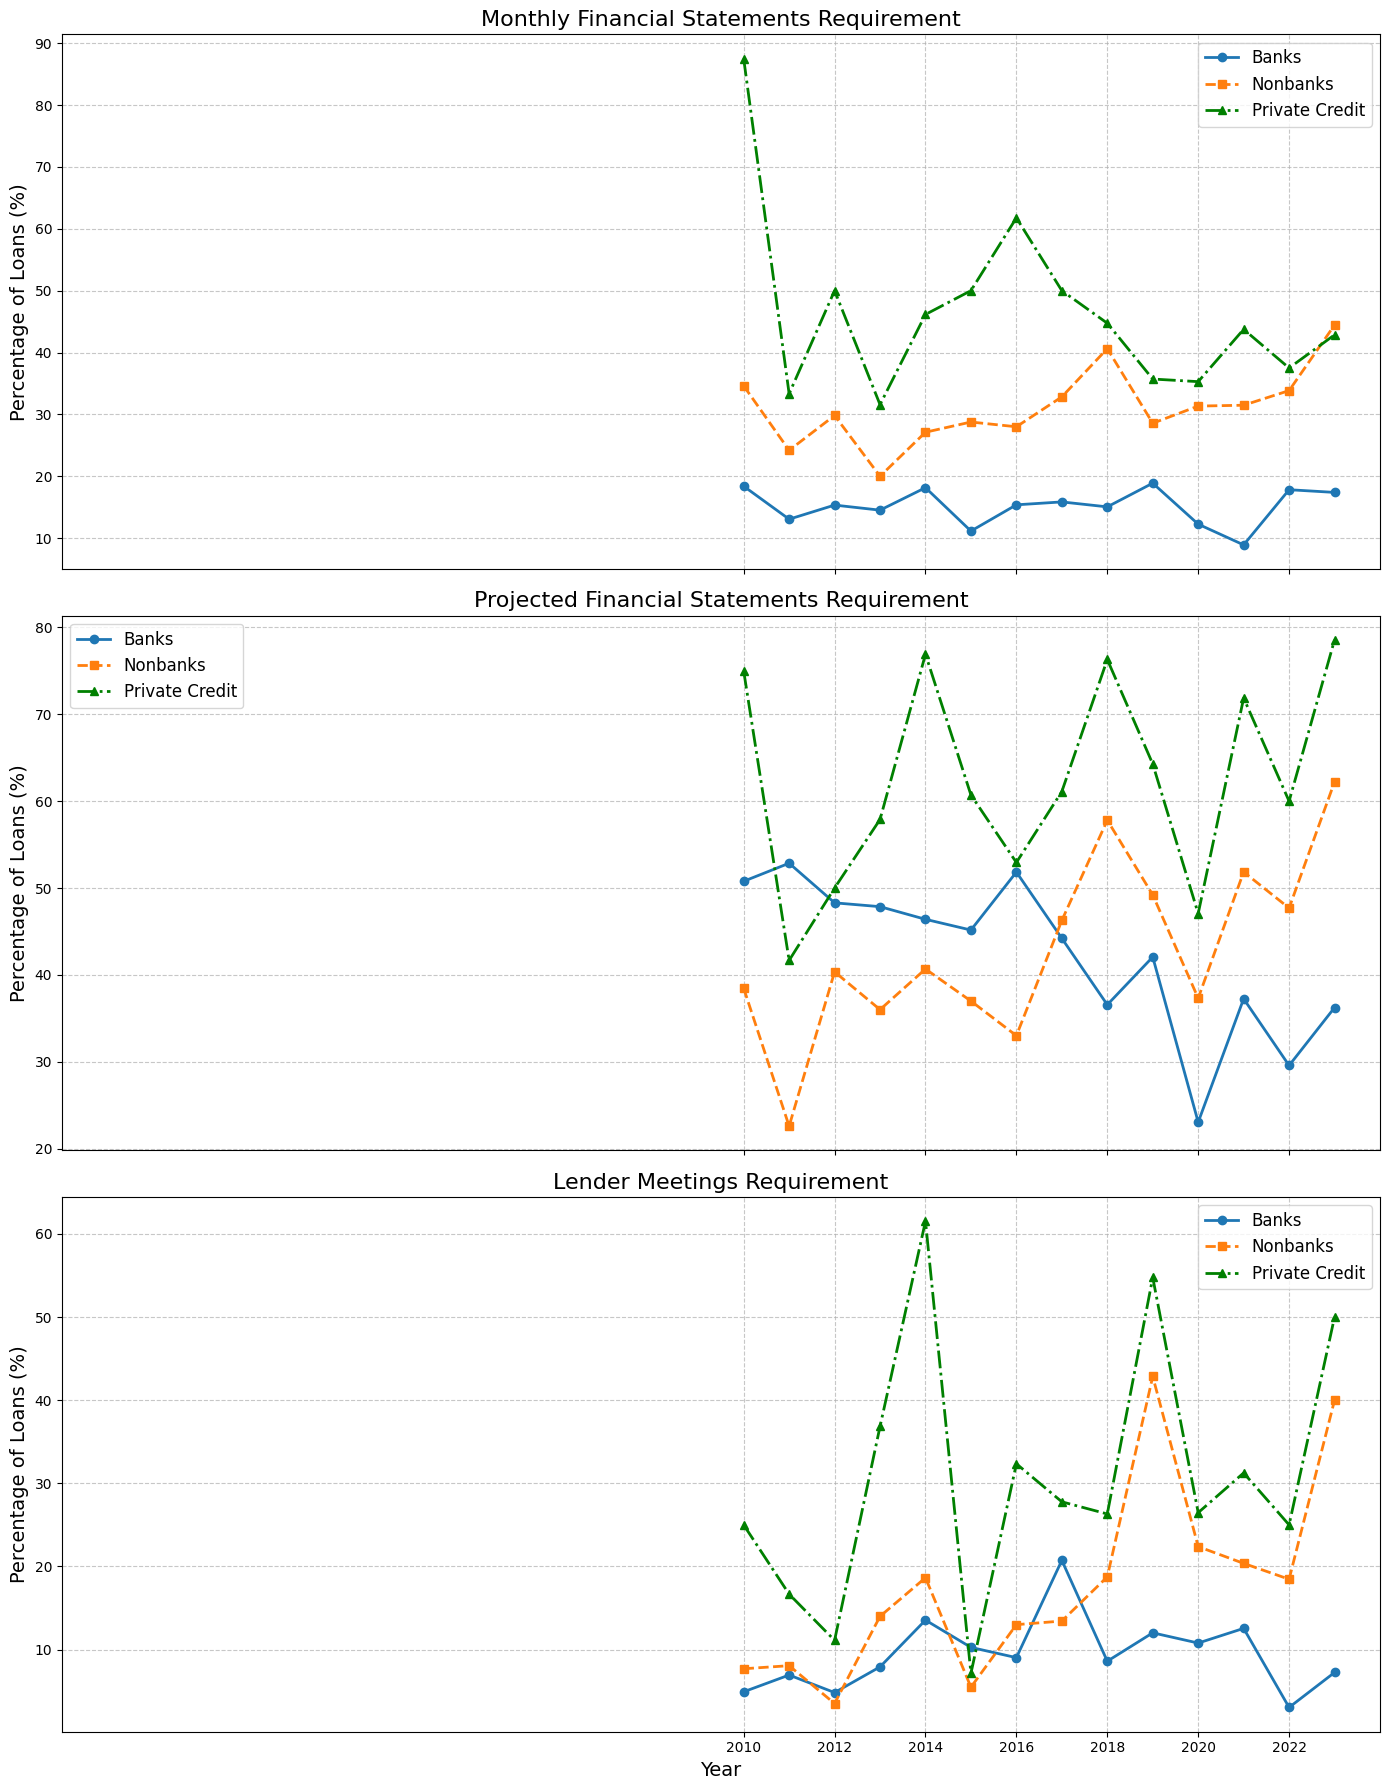

In [17]:
plot_lender_type_trends(merged_data)
plot_covenant_requirements_by_lender_type(merged_data)

In [18]:
# keep if nonbank_lender is 1
nonbank_lender_checks = merged_data[merged_data['nonbank_lender'] == 1]

# keep lead_arranger, standardized_lead_arranger, and nonbank_lender, and private_credit_lender
nonbank_lender_checks = nonbank_lender_checks[['lead_arranger', 'standardized_lead_arranger', 'nonbank_lender', 'private_credit_lender', 'monthly_fs', 'projected_fs', 'lender_meeting']].copy()

In [19]:
lender_checks = merged_data[['lead_arranger', 'standardized_lead_arranger', 'nonbank_lender', 'private_credit_lender', 'monthly_fs', 'projected_fs', 'lender_meeting']].copy()

Borrower Revenue Statistics by Lender Type:
   Lender Type  Count  Max Revenue ($M)  90th Percentile Revenue ($M)
          Bank   4177           -134.92                         61.74
       Nonbank    878              0.00                          1.95
Private Credit    364              0.00                          0.17


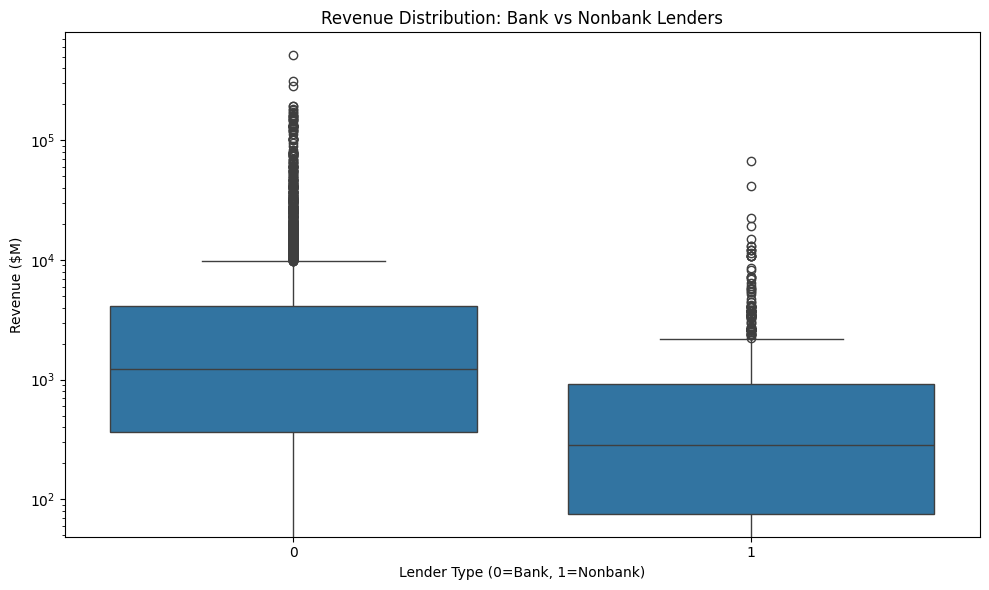

In [20]:
# Calculate statistics for nonbank vs bank lenders
bank_data = merged_data[merged_data['nonbank_lender'] == 0]
nonbank_data = merged_data[merged_data['nonbank_lender'] == 1]
pc_data = merged_data[merged_data['private_credit_lender'] == 1]

# Create a dataframe to store the results
summary_df = pd.DataFrame({
    'Lender Type': ['Bank', 'Nonbank', 'Private Credit'],
    'Count': [len(bank_data), len(nonbank_data), len(pc_data)],
    'Max Revenue ($M)': [
        bank_data['last_year_revenue'].min(),
        nonbank_data['last_year_revenue'].min(),
        pc_data['last_year_revenue'].min() if len(pc_data) > 0 else None
    ],
    '90th Percentile Revenue ($M)': [
        bank_data['last_year_revenue'].quantile(0.05),
        nonbank_data['last_year_revenue'].quantile(0.05),
        pc_data['last_year_revenue'].quantile(0.05) if len(pc_data) > 0 else None
    ]
})

# Display the statistics
print("Borrower Revenue Statistics by Lender Type:")
print(summary_df.to_string(index=False, float_format='{:.2f}'.format))

# Create a figure for visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='nonbank_lender', y='last_year_revenue', data=merged_data)
plt.title('Revenue Distribution: Bank vs Nonbank Lenders')
plt.xlabel('Lender Type (0=Bank, 1=Nonbank)')
plt.ylabel('Revenue ($M)')
plt.yscale('log')  # Using log scale due to skewed distribution
plt.tight_layout()
plt.show()

In [21]:
# keep if last_year_revenue is between 10 and 1000
merged_data = merged_data[(merged_data['last_year_revenue'] >= 10) & (merged_data['last_year_revenue'] <= 2000)]

In [22]:
preqin_names = pd.read_csv("../Data/Cleaned/preqin_names.csv")

In [23]:
from thefuzz import fuzz
from thefuzz import process
import pandas as pd
import numpy as np
import time
import re

# Import necessary libraries for fuzzy string matching

# Function to clean and standardize lender names
def clean_lender_name(name):
    if pd.isna(name):
        return ""
    
    # Convert to lowercase
    name = str(name).lower()
    
    # Remove common suffixes and legal entity identifiers
    suffixes = [' llc', ' ltd', ' inc', ' corp', ' corporation', ' lp', ' l.p.', ' limited', 
                ' holdings', ' group', ', inc.', ', llc', ' company', ' co.', ' plc', ' n.a.',
                ' gmbh', ' ag', ' partners', ' & co', ' and co', ' asset management']
    
    for suffix in suffixes:
        name = name.replace(suffix, '')
    
    # Replace special characters with spaces
    name = re.sub(r'[^\w\s]', ' ', name)
    
    # Remove extra whitespaces
    name = ' '.join(name.split())
    
    return name

# Clean the lender names in both datasets
print("Cleaning lender names...")
merged_data['clean_lead_arranger'] = merged_data['lead_arranger'].apply(clean_lender_name)
preqin_names['clean_lender_name'] = preqin_names['lender_name_cleaned'].apply(clean_lender_name)

# Create a dictionary of preqin lenders for faster lookup
preqin_dict = {name: (idx, name_orig) for idx, (name, name_orig) in 
               enumerate(zip(preqin_names['clean_lender_name'], preqin_names['lender_name_cleaned']))}

# Function to find best match from preqin database
def find_best_match(lender_name, threshold=80):
    if not lender_name or len(lender_name) < 3:
        return None, 0, None
    
    # Get top 3 matches
    matches = process.extract(lender_name, preqin_dict.keys(), limit=3, 
                              scorer=fuzz.token_sort_ratio)
    
    if matches and matches[0][1] >= threshold:
        match_name = matches[0][0]
        idx, original_name = preqin_dict[match_name]
        return original_name, matches[0][1], preqin_names.iloc[idx]['industry_1']
    
    return None, 0, None

# Apply matching to a sample first to check performance
sample_size = min(100, len(merged_data))
print(f"Testing with sample of {sample_size} records...")
sample = merged_data.head(sample_size)

# Time the operation on the sample to estimate full run time
start = time.time()
sample_results = [find_best_match(name) for name in sample['clean_lead_arranger']]
sample_time = time.time() - start

# Estimate full run time
est_time = (len(merged_data) / sample_size) * sample_time
print(f"Estimated time for full dataset: {est_time:.1f} seconds")

# Proceed with full matching
print("Matching lenders with Preqin database...")
results = [find_best_match(name) for name in merged_data['clean_lead_arranger']]

# Extract results
preqin_lender_names = [r[0] for r in results]
match_scores = [r[1] for r in results]
preqin_industries = [r[2] for r in results]

# Add results to the dataframe
merged_data['preqin_lender_match'] = preqin_lender_names
merged_data['match_score'] = match_scores
merged_data['preqin_industry'] = preqin_industries

# Flag loans where lender is matched to a known private credit entity based on industry
merged_data['preqin_private_credit'] = merged_data['preqin_industry'].isin([
    'Private Equity', 'Private Debt', 'Venture Capital', 'Credit', 'Alternative Credit', 
    'Real Estate', 'Infrastructure', 'Private Capital'
])

# Update private_credit_lender flag if preqin match indicates private credit
merged_data['private_credit_lender'] = merged_data['private_credit_lender'] | merged_data['preqin_private_credit']

# Count number of lenders matched to Preqin database
matched_count = (merged_data['match_score'] >= 80).sum()
print(f"Matched {matched_count} lenders to Preqin database ({matched_count/len(merged_data)*100:.1f}%)")

# Count number of additional private credit lenders identified
additional_pc = ((merged_data['preqin_private_credit'] == True) & (merged_data['private_credit_lender'] == False)).sum()
print(f"Identified {additional_pc} additional private credit lenders")

# Display top private credit industries found
if additional_pc > 0:
    pc_industries = merged_data[merged_data['preqin_private_credit']]['preqin_industry'].value_counts().head(10)
    print("\nTop private credit industries matched:")
    print(pc_industries)

Cleaning lender names...
Testing with sample of 100 records...
Estimated time for full dataset: 7.6 seconds
Matching lenders with Preqin database...
Matched 2425 lenders to Preqin database (76.5%)
Identified 0 additional private credit lenders


In [24]:
# save as CSV for backup/compatibility
csv_path = "../Data/Cleaned/agreements_mm_clean202503.csv"
merged_data.to_csv(csv_path, index=False)

In [ ]:
# Clean and standardize lead_arranger names
print("Cleaning and standardizing lead_arranger names...")

def clean_lead_arranger_name(name):
    if pd.isna(name):
        return name
    
    # Convert to lowercase
    cleaned = str(name).lower()
    # Remove "n.a." or "n a" at the end of bank names (like "bmo bank n.a." or "bmo bank n a")
    cleaned = re.sub(r'\s+n\.?\s*a\.?$', '', cleaned)
    # Remove ", llc" or ", n.a." strings
    cleaned = re.sub(r',\s*llc', '', cleaned)
    cleaned = re.sub(r',\s*\.\.', '', cleaned)
    
    # Remove special characters
    cleaned = re.sub(r'[^\w\s]', ' ', cleaned)
    
    # Remove common suffixes like LLC, N.A., etc.
    cleaned = re.sub(r'\b(llc|l\.?l\.?c\.?|\.\.?|inc\.?|corp\.?|corporation|limited|ltd\.?)\b', '', cleaned)
    
    # Remove extra whitespaces (including leading/trailing)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    
    return cleaned

# Apply the cleaning function to lead_arranger column
merged_data['clean_lead_arranger'] = merged_data['lead_arranger'].apply(clean_lead_arranger_name)

# Check how many unique lead arrangers before and after cleaning
original_count = merged_data['lead_arranger'].nunique()
cleaned_count = merged_data['clean_lead_arranger'].nunique()

print(f"Original unique lead arrangers: {original_count}")
print(f"Cleaned unique lead arrangers: {cleaned_count}")
print(f"Reduced by: {original_count - cleaned_count} ({(original_count - cleaned_count)/original_count*100:.1f}%)")

# Display a sample of before and after cleaning
sample_size = min(5, len(merged_data))
sample_indices = np.random.choice(merged_data.index, sample_size, replace=False)
sample_data = merged_data.loc[sample_indices, ['lead_arranger', 'clean_lead_arranger']]
print("\nSample of cleaned lead arranger names:")
print(sample_data)

# Generate lender IDs using fuzzy matching
print("\nGenerating lender IDs using fuzzy matching...")

# Get unique cleaned lender names
unique_lenders = merged_data['clean_lead_arranger'].dropna().unique()
print(f"Found {len(unique_lenders)} unique lenders after cleaning")

# Create a dictionary to store lender IDs
lender_id_map = {}
next_id = 1

Cleaning and standardizing lead_arranger names...
Original unique lead arrangers: 672
Cleaned unique lead arrangers: 530
Reduced by: 142 (21.1%)

Sample of cleaned lead arranger names:
                              lead_arranger               clean_lead_arranger
6745                  BANK OF AMERICA, N.A.                   bank of america
6391                 IEP ENERGY HOLDING LLC                iep energy holding
6375       Deutsche Bank AG New York Branch  deutsche bank ag new york branch
1585  inter-american investment corporation         inter american investment
1077           The Huntington National Bank      the huntington national bank

Generating lender IDs using fuzzy matching...
Found 530 unique lenders after cleaning
Assigned 498 unique lender IDs from 530 cleaned lender names
Reduced by: 32 (6.0%)

Sample of assigned lender IDs:
                                   lead_arranger  \
2600                   JPMorgan Chase Bank, N.A.   
1335                             SWK Fund

In [25]:
# Check for any remaining infinity values in the entire DataFrame
inf_columns = []
for col in merged_data.columns:
    if merged_data[col].dtype.kind == 'f':  # Only check numeric columns
        if np.isinf(merged_data[col]).any():
            inf_columns.append(col)
            # Replace inf values without chained assignment
            merged_data.loc[:, col] = merged_data[col].replace([np.inf, -np.inf], np.nan)

if inf_columns:
    print(f"Replaced infinity values in: {', '.join(inf_columns)}")

# Add industry_2 and industry_3 from Preqin data when we have a match
# First create a mapping from lender name to industries
industry_mapping = {}
for _, row in preqin_names.iterrows():
    industry_mapping[row['lender_name_cleaned']] = (row['industry_1'], row['industry_2'], row['industry_3'])

# Add the columns if they don't already exist
if 'preqin_industry_1' not in merged_data.columns:
    merged_data['preqin_industry_1'] = merged_data['preqin_industry']  # Rename existing column
if 'preqin_industry_2' not in merged_data.columns:
    merged_data['preqin_industry_2'] = np.nan
if 'preqin_industry_3' not in merged_data.columns:
    merged_data['preqin_industry_3'] = np.nan

# Update industry columns where we have a match
matched_mask = ~merged_data['preqin_lender_match'].isna()
for idx in merged_data[matched_mask].index:
    lender_name = merged_data.at[idx, 'preqin_lender_match']
    if lender_name in industry_mapping:
        ind1, ind2, ind3 = industry_mapping[lender_name]
        merged_data.at[idx, 'preqin_industry_1'] = ind1
        merged_data.at[idx, 'preqin_industry_2'] = ind2
        merged_data.at[idx, 'preqin_industry_3'] = ind3

# Rename preqin_industry columns to industry_1, industry_2, industry_3
merged_data.rename(columns={
    'preqin_industry_1': 'industry_1',
    'preqin_industry_2': 'industry_2',
    'preqin_industry_3': 'industry_3'
}, inplace=True)

# Check for column names longer than 32 characters (Stata's limit)
long_columns = [col for col in merged_data.columns if len(col) > 32]
rename_dict = {}
if long_columns:
    print(f"Warning: These column names exceed Stata's 32 character limit: {long_columns}")
    # Rename columns to meet Stata requirements
    for col in long_columns:
        new_name = col[:32]
        rename_dict[col] = new_name
        print(f"Renamed '{col}' to '{new_name}'")
    
    # Apply all renames at once
    if rename_dict:
        merged_data = merged_data.rename(columns=rename_dict)

# Clean string columns to handle Unicode characters
for col in merged_data.columns:
    if merged_data[col].dtype == 'object':
        # Replace Unicode characters with ASCII equivalents
        merged_data.loc[:, col] = merged_data[col].astype(str).str.replace('\u2014', '-')  # Replace em dash with hyphen
        merged_data.loc[:, col] = merged_data[col].astype(str).str.replace('\u2013', '-')  # Replace en dash with hyphen
        merged_data.loc[:, col] = merged_data[col].astype(str).str.replace('\u2019', "'")  # Replace right single quotation mark
        merged_data.loc[:, col] = merged_data[col].astype(str).str.replace('\u201c', '"')  # Replace left double quotation mark
        merged_data.loc[:, col] = merged_data[col].astype(str).str.replace('\u201d', '"')  # Replace right double quotation mark

# Check for missing values in columns intended to be used as identifiers in Stata
id_columns = ['gvkey', 'year', 'quarter_x']
missing_ids = {col: merged_data[col].isna().sum() for col in id_columns}
if any(missing_ids.values()):
    print("Warning: Missing values in identifier columns:")
    for col, count in missing_ids.items():
        if count > 0:
            print(f"  - {col}: {count} missing values")

# Save the cleaned data as a Stata file
stata_path = "../Data/Cleaned/agreements_mm_clean202503.dta"
try:
    merged_data.to_stata(stata_path, write_index=False, version=118)
    print(f"Data saved to {stata_path}")
except Exception as e:
    print(f"Error saving to Stata format: {e}")
    # Fallback to CSV if Stata save fails
    csv_backup = "../Data/Cleaned/agreements_mm_clean202503_backup.csv"
    merged_data.to_csv(csv_backup, index=False)
    print(f"Saved backup to CSV: {csv_backup}")

Replaced infinity values in: sales_growth, leverage_growth
Renamed 'private_credit_lender_standardized' to 'private_credit_lender_standardiz'


/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_19392/2615878778.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Consumer Discretionary' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.at[idx, 'preqin_industry_2'] = ind2
/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_19392/2615878778.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Business Services' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.at[idx, 'preqin_industry_3'] = ind3


Data saved to ../Data/Cleaned/agreements_mm_clean202503.dta
